In [2]:
import pandas as pd
import wrangle
import model
import model_MAE

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
from scipy import stats

In [3]:
df, train_exp, X_train_scaled, y_train, X_test_scaled, y_test = wrangle.wrangle_data()

Acquire: compiling raw data files...
Acquire: Completed!
Prepare: preparing data files...
Prepare: Completed!
(289, 25) (73, 25)


In [4]:
X_train_scaled.columns

Index(['raw_svi', 'f_pov_soci', 'f_unemp_soci', 'f_pci_soci', 'f_nohsdp_soci',
       'f_age65_comp', 'f_age17_comp', 'f_disabl_comp', 'f_sngpnt_comp',
       'f_minrty_status', 'f_limeng_status', 'f_munit_trans', 'f_mobile_trans',
       'f_crowd_trans', 'f_noveh_trans', 'f_groupq_trans',
       'f_soci_total_scaled', 'f_comp_total_scaled', 'f_status_total_scaled',
       'f_trans_total_scaled', 'all_flags_total_scaled', 'rank_svi_scaled'],
      dtype='object')

# Create Baseline

In [5]:
y_train.tract_cases_per_100k.mean(), y_train.tract_cases_per_100k.median()

(3221.1574384513838, 2911.8640437)

In [6]:
# MAE
mean_baseMAE, basepred1 = model_MAE.get_baseline_mean(y_train)

Baseline MAE: 991.6409214408791


In [7]:
# using mean
mean_baseRMSE, basepred = model.get_baseline_mean(y_train)

Baseline RMSE: 1286.8011415555738


In [8]:
# using median
median_baseMAE, basepred2 = model_MAE.get_baseline_median(y_train)

Baseline MAE: 972.4419410631488


In [9]:
# using median
median_baseRMSE, basepred = model.get_baseline_median(y_train)

Baseline RMSE: 1323.4498788943854


# Feature Ranking

In [10]:
# possible feature ranking?
rankdf = model.feature_ranking(X_train_scaled, y_train)
rankdf

,features
rank,
1,rank_svi_scaled
2,f_nohsdp_soci
3,f_minrty_status
4,f_groupq_trans
5,f_comp_total_scaled
6,f_unemp_soci
7,f_disabl_comp
8,f_noveh_trans
9,f_mobile_trans


# Create X_train_scaled df with selected features to test

## Feature groups to use for OLS, PF, and Tweedie models

In [11]:
# only raw svi score
X_raw_svi = X_train_scaled[['raw_svi']]
# binned svi score by CDC range category = 1st ranked
X_rank_svi_only = X_train_scaled[['rank_svi_scaled']]
# top 4 ranked features
X_top4 = X_train_scaled[['rank_svi_scaled', 'f_nohsdp_soci', 'f_minrty_status', 'f_groupq_trans']]
# only the summary of the flags = 19th ranked
X_all_flags_only = X_train_scaled[['all_flags_total_scaled']]
# only summary flags, should be the same as all flags total? = 5th, 12th, 15th, 21st
X_summary_flags = X_train_scaled[['f_comp_total_scaled', 'f_soci_total_scaled', 'f_status_total_scaled', 'f_trans_total_scaled']]
# all individual flags
X_not_summary_flags = X_train_scaled[['f_nohsdp_soci', 'f_minrty_status', 'f_groupq_trans', 'f_unemp_soci', 
                                     'f_disabl_comp', 'f_noveh_trans', 'f_mobile_trans', 'f_age65_comp', 
                                     'f_age17_comp', 'f_pov_soci', 'f_limeng_status', 'f_crowd_trans', 
                                      'f_pci_soci', 'f_sngpnt_comp', 'f_munit_trans']]

## LassoLars
- includes feature selection as part of model so will use all features on this model

## Drilling in features to test -- RETURN HERE

- what is the score using only 1 summary flag at a time?
    - if one summary group is better might be worth investigating for which features within group have greatest impact?

# Run df through regression algorithms

In [12]:
# create variables for loop
df2test = [X_rank_svi_only, X_top4, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled, X_raw_svi]
target = y_train

# Linear Regression Models
lm_MAE_list = []
for df in df2test:
    lm_MAE = model_MAE.linear_reg_train(df, target)
    lm_MAE_list.append(lm_MAE)

# Polynomial Features 2 degree
pf2_MAE_list = []
for df in df2test:
    pf2_MAE = model_MAE.polynomial2(df, target)
    pf2_MAE_list.append(pf2_MAE)

# Tweedie power=0, alpha=.5
tweedie05 = []
for df in df2test:
    tw_MAE = model_MAE.tweedie05(df, target)
    tweedie05.append(tw_MAE)


In [13]:
# # create variables for loop
# df2test = [X_rank_svi_only, X_top5, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled]
# target = y_train

# # Linear Regression Models
# lm_RMSE_list = []
# for df in df2test:
#     lm_RMSE = model.linear_reg_train(df, target)
#     lm_RMSE_list.append(lm_RMSE)

# # Polynomial Features 2 degree
# pf2_RMSE_list = []
# for df in df2test:
#     pf2_RMSE = model.polynomial2(df, target)
#     pf2_RMSE_list.append(pf2_RMSE)

# # Tweedie power=0, alpha=.5
# tweedie05 = []
# for df in df2test:
#     tw_RMSE = model.tweedie05(df, target)
#     tweedie05.append(tw_RMSE)


In [14]:
# LassoLars Models
lars_MAE = model_MAE.lasso_lars(X_train_scaled, target)

In [15]:
# LassoLars Models
lars_RMSE = model.lasso_lars(X_train_scaled, target)

# Summarize in results df

In [16]:
# create dataframe for results of all train models
df_list = ['rank_svi_only', 'top5', 'total_all_flags_only', 'summary_flags', 'not_summary_flags', 'all_features', 'raw_svi_only']

results = pd.DataFrame(df_list, columns=['Features'])
results['LinearRegression_MAE'] = lm_MAE_list
results['Tweedie05_MAE'] = tweedie05
results['PolynomialFeatures2_MAE'] = pf2_MAE_list
results['LassoLars_MAE'] = lars_MAE
results['Base_mean_MAE'] = mean_baseMAE
results['Base_median_MAE'] = median_baseMAE
results.sort_values('PolynomialFeatures2_MAE')

,Features,LinearRegression_MAE,Tweedie05_MAE,PolynomialFeatures2_MAE,LassoLars_MAE,Base_mean_MAE,Base_median_MAE
5,all_features,694.465209,827.637470,465.445384,693.707642,991.640921,972.441941
4,not_summary_flags,786.881614,900.810270,530.442453,693.707642,991.640921,972.441941
1,top5,716.161912,885.014499,710.919196,693.707642,991.640921,972.441941
6,raw_svi_only,781.751090,942.005025,772.131633,693.707642,991.640921,972.441941
0,rank_svi_only,783.145392,917.511392,781.326882,693.707642,991.640921,972.441941
3,summary_flags,823.656119,962.109229,785.635693,693.707642,991.640921,972.441941
2,total_all_flags_only,857.440941,976.431400,857.232422,693.707642,991.640921,972.441941


In [17]:
# # create dataframe for results of all train models
# df_list = ['rank_svi_only', 'top5', 'total_all_flags_only', 'summary_flags', 'not_summary_flags', 'all_features', 'raw_svi_only']

# results = pd.DataFrame(df_list, columns=['Features'])
# results['LinearRegression_RMSE'] = lm_RMSE_list
# results['Tweedie05_RMSE'] = tweedie05
# results['PolynomialFeatures2_RMSE'] = pf2_RMSE_list
# results['LassoLars_RMSE'] = lars_RMSE
# results['Base_mean_RMSE'] = mean_baseRMSE
# results['Base_median_RMSE'] = median_baseRMSE
# results.sort_values('PolynomialFeatures2_RMSE')

# Validate Stage

## pick models to validate
- LassoLars
- LR all feature
- PF2 all features
- PF2 top5


In [18]:
from numpy import mean
from numpy import std, absolute
from sklearn.datasets import make_blobs
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

In [19]:
# LassoLars
# create loocv procedure
cvLL = LeaveOneOut()
# create model
modelLL = LassoLars(alpha=1)
# evaluate model
scoresLL = cross_val_score(modelLL, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cvLL, n_jobs=-1)
# force positive
scoresLL = absolute(scoresLL)
# report performance
print('MAE: %.3f (%.3f)' % (mean(scoresLL), std(scoresLL)))

MAE: 743.953 (739.219)


In [20]:
# Linear Regression - all features
# create loocv procedure
cvLR = LeaveOneOut()
# create model
modelLR = LinearRegression()
# evaluate model
scoresLR = cross_val_score(modelLR, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cvLR, n_jobs=-1)
# force positive
scoresLR = absolute(scoresLR)
# report performance
print('MAE: %.3f (%.3f)' % (mean(scoresLR), std(scoresLR)))

MAE: 751.477 (743.994)


In [21]:
# Polynomial Features 2 degrees - all features
# create loocv procedure
cvPF1 = LeaveOneOut()

# create PF object
pf1 = PolynomialFeatures(degree=2)
# Fit and Transform model to get a new set of features...which are the original features squared
X_train_squared1 = pf1.fit_transform(X_train_scaled)

# create model
modelPF1 = LinearRegression(normalize=True)
# evaluate model
scoresPF1 = cross_val_score(modelPF1, X_train_squared1, y_train, scoring='neg_mean_absolute_error', cv=cvPF1, n_jobs=-1)
# force positive
scoresPF1 = absolute(scoresPF1)
# report performance
print('MAE: %.3f (%.3f)' % (mean(scoresPF1), std(scoresPF1)))

MAE: 528127943495245.500 (2715096445521437.500)


In [22]:
# Polynomial Features 2 degrees - top 5
# create loocv procedure
cvPF2 = LeaveOneOut()

# create PF object
pf2 = PolynomialFeatures(degree=2)
# Fit and Transform model to get a new set of features...which are the original features squared
X_train_squared2 = pf2.fit_transform(X_top4)

# create model
modelPF2 = LinearRegression(normalize=True)
# evaluate model
scoresPF2 = cross_val_score(modelPF2, X_train_squared2, y_train, scoring='neg_mean_absolute_error', cv=cvPF2, n_jobs=-1)
# force positive
scoresPF2 = absolute(scoresPF2)
# report performance
print('MAE: %.3f (%.3f)' % (mean(scoresPF2), std(scoresPF2)))

MAE: 753.841 (672.284)


# Test 

In [23]:
# fit model from cross validation to train dataset
modelLL.fit(X_train_scaled, y_train)
# use the trained dataset to predict on test
lars_test_pred = modelLL.predict(X_test_scaled)
# get the MAE of test
lars_MAE = mean_absolute_error(y_test, lars_test_pred)
print('MAE: %.3f' % lars_MAE)

MAE: 743.214


In [65]:
modelLL.coef_

array([  200.24132732,  -104.04456837,   552.15048285,    43.01829835,
         732.9447024 ,  -406.85411484,  -400.81924233,   194.45940519,
         -61.19539343,   627.25148361,     0.        ,     0.        ,
        -306.04948748,   -35.57377956,  -411.02942466,   594.20107936,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        , -1220.8470301 ])

In [66]:
X_train_scaled.head()

,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_age65_comp,f_age17_comp,f_disabl_comp,f_sngpnt_comp,f_minrty_status,...,f_mobile_trans,f_crowd_trans,f_noveh_trans,f_groupq_trans,f_soci_total_scaled,f_comp_total_scaled,f_status_total_scaled,f_trans_total_scaled,all_flags_total_scaled,rank_svi_scaled
289,0.4879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.000000,0.0,0.000000,0.000000,0.666667
200,0.6394,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.000000,0.0,0.333333,0.111111,0.333333
69,0.6523,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0.0,0.000000,0.5,0.333333,0.222222,0.333333
29,0.0872,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.000000,0.0,0.000000,0.000000,1.000000
12,0.9531,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0.0,0.333333,0.0,0.000000,0.111111,0.000000


In [51]:
ll_coef_count = (modelLL.coef_ != 0)

In [61]:
ll_coef = modelLL.coef_ 

In [62]:
ll_coef

array([  200.24132732,  -104.04456837,   552.15048285,    43.01829835,
         732.9447024 ,  -406.85411484,  -400.81924233,   194.45940519,
         -61.19539343,   627.25148361,     0.        ,     0.        ,
        -306.04948748,   -35.57377956,  -411.02942466,   594.20107936,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        , -1220.8470301 ])

In [56]:
rankdf

,features
rank,
1,rank_svi_scaled
2,f_nohsdp_soci
3,f_minrty_status
4,f_groupq_trans
5,f_comp_total_scaled
6,f_unemp_soci
7,f_disabl_comp
8,f_noveh_trans
9,f_mobile_trans


In [104]:
ll_result = pd.DataFrame()
x_train_columns = X_train_scaled.columns.tolist()
ll_result['features'] = x_train_columns
ll_result['coefs'] = modelLL.coef_
ll_result['abs_coefs'] = abs(modelLL.coef_)
ll_result.sort_values(by = 'abs_coefs', ascending = False)

,features,coefs,abs_coefs
21,rank_svi_scaled,-1220.847030,1220.847030
4,f_nohsdp_soci,732.944702,732.944702
9,f_minrty_status,627.251484,627.251484
15,f_groupq_trans,594.201079,594.201079
2,f_unemp_soci,552.150483,552.150483
14,f_noveh_trans,-411.029425,411.029425
5,f_age65_comp,-406.854115,406.854115
6,f_age17_comp,-400.819242,400.819242
12,f_mobile_trans,-306.049487,306.049487
0,raw_svi,200.241327,200.241327


In [106]:
rank_df = rankdf.copy()
rank_df = rank_df.reset_index()
rank_df

,rank,features
0,1,rank_svi_scaled
1,2,f_nohsdp_soci
2,3,f_minrty_status
3,4,f_groupq_trans
4,5,f_comp_total_scaled
5,6,f_unemp_soci
6,7,f_disabl_comp
7,8,f_noveh_trans
8,9,f_mobile_trans
9,10,f_age65_comp


In [111]:
comparison = pd.merge(ll_result, rank_df, on = 'features', how = 'inner')
comparison = comparison.reset_index()

In [112]:
comparison

,index,features,coefs,abs_coefs,rank
0,0,raw_svi,200.241327,200.241327,14
1,1,f_pov_soci,-104.044568,104.044568,13
2,2,f_unemp_soci,552.150483,552.150483,6
3,3,f_pci_soci,43.018298,43.018298,18
4,4,f_nohsdp_soci,732.944702,732.944702,2
5,5,f_age65_comp,-406.854115,406.854115,10
6,6,f_age17_comp,-400.819242,400.819242,11
7,7,f_disabl_comp,194.459405,194.459405,7
8,8,f_sngpnt_comp,-61.195393,61.195393,20
9,9,f_minrty_status,627.251484,627.251484,3


In [110]:
rfe_ll_comp.sort_values(by = 'abs_coefs', ascending = False)

,index,features,coefs,abs_coefs,rank
21,21,rank_svi_scaled,-1220.847030,1220.847030,1
4,4,f_nohsdp_soci,732.944702,732.944702,2
9,9,f_minrty_status,627.251484,627.251484,3
15,15,f_groupq_trans,594.201079,594.201079,4
2,2,f_unemp_soci,552.150483,552.150483,6
14,14,f_noveh_trans,-411.029425,411.029425,8
5,5,f_age65_comp,-406.854115,406.854115,10
6,6,f_age17_comp,-400.819242,400.819242,11
12,12,f_mobile_trans,-306.049487,306.049487,9
0,0,raw_svi,200.241327,200.241327,14


In [99]:
abs(ll_coef)

array([ 200.24132732,  104.04456837,  552.15048285,   43.01829835,
        732.9447024 ,  406.85411484,  400.81924233,  194.45940519,
         61.19539343,  627.25148361,    0.        ,    0.        ,
        306.04948748,   35.57377956,  411.02942466,  594.20107936,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        , 1220.8470301 ])

In [100]:
abs(modelLL.coef_)

array([ 200.24132732,  104.04456837,  552.15048285,   43.01829835,
        732.9447024 ,  406.85411484,  400.81924233,  194.45940519,
         61.19539343,  627.25148361,    0.        ,    0.        ,
        306.04948748,   35.57377956,  411.02942466,  594.20107936,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        , 1220.8470301 ])

In [101]:
modelLL.coef_

array([  200.24132732,  -104.04456837,   552.15048285,    43.01829835,
         732.9447024 ,  -406.85411484,  -400.81924233,   194.45940519,
         -61.19539343,   627.25148361,     0.        ,     0.        ,
        -306.04948748,   -35.57377956,  -411.02942466,   594.20107936,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        , -1220.8470301 ])

In [148]:
m_log_alphas = -np.log10(modelLL.alphas_) # alpha contains the values of alpha through the model selection process.

In [151]:
import numpy as np

Text(0.5, 1.0, 'Regression Coefficients Progression for Lasso Paths')

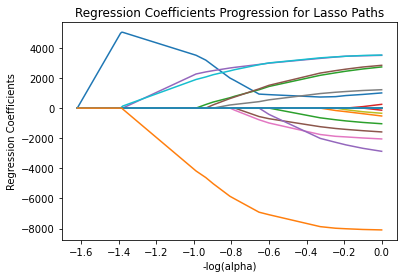

In [161]:
%matplotlib inline
ax = plt.gca()

m_log_alphas = -np.log10(modelLL.alphas_) # alpha contains the values of alpha through the model selection process.
plt.plot(m_log_alphas, modelLL.coef_path_.T) # change in regression coefficient
np.shape(modelLL.coef_path_), np.shape(m_log_alphas)

# plt.axvline(-np.log10(modelLL.alphas_), linestyle='--', color='k',
#             label='alpha CV')

plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')


In [158]:
modelLL.alphas_

array([41.7549418 , 24.58619378, 24.22137797, 23.92548153,  9.73351739,
        8.64033345,  7.8848992 ,  6.42606862,  6.05276142,  4.49655441,
        3.98054126,  2.1235434 ,  1.76074209,  1.54913459,  1.2584607 ,
        1.        ])

In [ ]:
ll_paths = modelLL.coef_path_

In [85]:
import mglearn

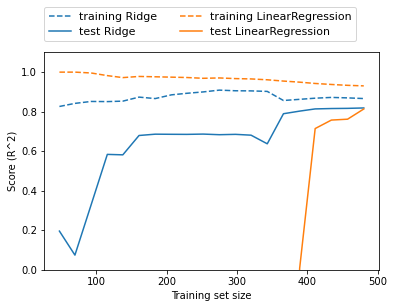

In [86]:
mglearn.plots.plot_ridge_n_samples()

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

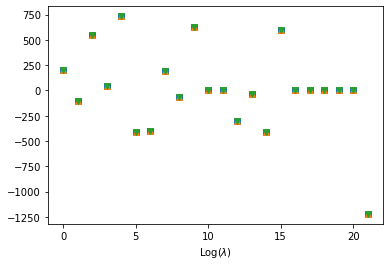

In [94]:
plt.plot(modelLL.coef_, 's', label="Lasso alpha=1")
plt.plot(modelLL.coef_, '^', label="Lasso alpha=0.01")
plt.plot(modelLL.coef_, 'v', label="Lasso alpha=0.0001")
plt.xlabel('Log($\\lambda$)')
plt.show()

In [26]:
modelLL.intercept_

array([3580.43021804])

In [28]:
modelLL.n_iter_

15

In [29]:
modelLL.alphas_

array([41.7549418 , 24.58619378, 24.22137797, 23.92548153,  9.73351739,
        8.64033345,  7.8848992 ,  6.42606862,  6.05276142,  4.49655441,
        3.98054126,  2.1235434 ,  1.76074209,  1.54913459,  1.2584607 ,
        1.        ])

In [127]:
modelLL.alphas_.shape, modelLL.coef_path_.shape

((16,), (22, 16))

In [114]:
m_log_alphas = -np.log10(modelLL.alphas_)

In [145]:
modelLL.coef_.T.shape

(22,)

NameError: name 'alphas_' is not defined

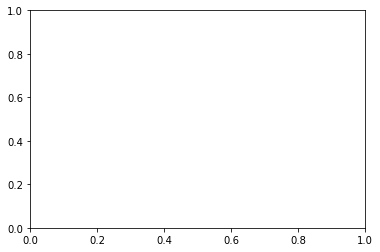

In [138]:
fig,ax = plt.subplots()
ax.plot(m_log_alphas, modelLL.coef_.T)
# Set log scale
ax.set_xscale('log')
# Make alpha decrease from left to right
ax.set_xlim(alphas_.max(), alphas_.min())

In [133]:
# I need to figure out a way to plot an array of lists = this is what I need to create that nice line chart I wanted to make.

modelLL.coef_path_[0].shape

(16,)

In [132]:
modelLL.coef_path_

array([[    0.        ,  4961.76817887,  5035.17013547,  5032.04447111,
         3507.23933173,  3184.98074173,  2815.66088487,  1995.77391349,
         1825.49925052,   929.95006522,   893.49987782,   734.77250082,
          760.11659549,   833.47433135,   907.7355796 ,  1006.61464586],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
         -158.89820108,  -237.43218689,  -371.59720394,  -523.20244018],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,   237.34843775,   402.64337448,   687.25861828,
          789.71835476,  1218.30150474,  1436.01975607,  2176.88064856,
         2341.87675855,  2449.38558823,  2597.57869246,  2731.75069758],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0

In [33]:
modelLL.coef_

array([  200.24132732,  -104.04456837,   552.15048285,    43.01829835,
         732.9447024 ,  -406.85411484,  -400.81924233,   194.45940519,
         -61.19539343,   627.25148361,     0.        ,     0.        ,
        -306.04948748,   -35.57377956,  -411.02942466,   594.20107936,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        , -1220.8470301 ])

In [44]:
from sklearn.linear_model import Lasso

In [ ]:
model

In [34]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import eli5

In [35]:
train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')
train_data = train_values.merge(train_labels, left_on='building_id', right_on='building_id')

In [36]:
train_data.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

In [37]:
train_data = train_data.drop('building_id', axis=1)
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).drop(['damage_grade'], axis=1).columns
categorical_features = train_data.select_dtypes(include=['object']).columns
X = train_data.drop('damage_grade', axis=1)
y = train_data['damage_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot', OneHotEncoder())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  LogisticRegression(class_weight='balanced', random_state=0))])
    
model = pipe.fit(X_train, y_train)

In [39]:
target_names = y_test.unique().astype(str)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           2       0.37      0.67      0.48      5000
           1       0.67      0.37      0.48     29521
           3       0.45      0.69      0.55     17600

    accuracy                           0.51     52121
   macro avg       0.50      0.58      0.50     52121
weighted avg       0.57      0.51      0.50     52121



In [40]:
onehot_columns = list(pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['one_hot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)

In [41]:
eli5.explain_weights(pipe.named_steps['classifier'], top=50, feature_names=numeric_features_list)

Explanation(estimator="LogisticRegression(class_weight='balanced', random_state=0)", description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='foundation_type_i', weight=0.4684911880354963, std=None, value=None), FeatureWeight(feature='ground_floor_type_v', weight=0.32208419787382075, std=None, value=None), FeatureWeight(feature='position_s', weight=0.3205276441409014, std=None, value=None), FeatureWeight(feature='other_floor_type_s', weight=0.29896473604254215, std=None, value=None), FeatureWeight(feature='roof_type_x', weight=0.22984578597198718, std=None, value=None), FeatureWeight(feature='foundation_type_w', weight=0.17605825908678402, std=None, value=None), FeatureWeight(feature='legal_ownership_status_a', weight=0.17420054292644008, std=None, value=None), FeatureWeight(feature='plan_configuration_a', weight=0.16909200889931073, std=None, value=None), FeatureWeight(feature='geo_level_1_id', weight=0.1542583216748475, std=None, value=None), FeatureWeight(feature='foundation_type_h', weight=0.12938505530693944, std=None, value=None), FeatureWeight(feature='plan_configuration_n', weight=0.1236150446279943, std=None, value=None), FeatureWeight(feature='has_superstructure_timber', weight=0.11167315068164307, std=None, value=None), FeatureWeight(feature='has_superstructure_cement_mortar_brick', weight=0.10421455444237689, std=None, value=None), FeatureWeight(feature='has_superstructure_rc_engineered', weight=0.10375247397765731, std=None, value=None), FeatureWeight(feature='plan_configuration_o', weight=0.10193915039038941, std=None, value=None), FeatureWeight(feature='legal_ownership_status_v', weight=0.0968331187696282, std=None, value=None), FeatureWeight(feature='land_surface_condition_t', weight=0.09642076681972211, std=None, value=None), FeatureWeight(feature='legal_ownership_status_r', weight=0.07850472703516209, std=None, value=None), FeatureWeight(feature='has_secondary_use_hotel', weight=0.07286824928473769, std=None, value=None), FeatureWeight(feature='plan_configuration_c', weight=0.06558552735395906, std=None, value=None), FeatureWeight(feature='has_secondary_use_rental', weight=0.06510936313707714, std=None, value=None), FeatureWeight(feature='plan_configuration_u', weight=0.06387098902787401, std=None, value=None), FeatureWeight(feature='has_superstructure_rc_non_engineered', weight=0.05733338685891476, std=None, value=None), FeatureWeight(feature='plan_configuration_s', weight=0.05673292457342604, std=None, value=None), FeatureWeight(feature='has_secondary_use_other', weight=0.055052115264536496, std=None, value=None), FeatureWeight(feature='has_superstructure_other', weight=0.043288070946703464, std=None, value=None)], neg=[FeatureWeight(feature='foundation_type_r', weight=-0.5038764266403732, std=None, value=None), FeatureWeight(feature='has_superstructure_mud_mortar_stone', weight=-0.3578815687494286, std=None, value=None), FeatureWeight(feature='legal_ownership_status_w', weight=-0.35026863696943855, std=None, value=None), FeatureWeight(feature='plan_configuration_q', weight=-0.29731419183965196, std=None, value=None), FeatureWeight(feature='foundation_type_u', weight=-0.2707883240270483, std=None, value=None), FeatureWeight(feature='roof_type_q', weight=-0.2597317563221212, std=None, value=None), FeatureWeight(feature='count_floors_pre_eq', weight=-0.2436153199912187, std=None, value=None), FeatureWeight(

In [43]:
numeric_features

Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other'],
      dtype='object')